In [17]:
import json
import pandas as pd

#### Load GPT Extracted Data

In [18]:
with open('../../outputs/nv_task/extractions/full_lb_nv_task-zeroshot_gpt-4o-mini-2024-07-18.json') as f:
    nv_task_gpt_json = json.load(f)

# Convert to dictionary and clean
nv_task_gpt = {}
for item in nv_task_gpt_json:
    pmcid = item['pmcid']
    nv_task_gpt[pmcid] = {}
    for key, value in item.items():
        value = None if value in ['null', []] else value
        if key == 'Designtype':
            key = 'DesignType'

        if key == 'Modality':
            value = [v.replace(' ', '') for v in value]

        nv_task_gpt[pmcid][key] = value



#### Load Annotations

In [19]:
from labelrepo.projects.nv_task import load_annotations

annotations = load_annotations()
annotations = annotations[annotations['annotator_name'] != 'alice_chen']

In [20]:
annotations.label_name.unique()

array(['TaskName', 'DesignType-RestingState', 'Modality-fMRI-BOLD',
       'ContrastDefinition', 'Modality-StructuralMRI',
       'Modality-DiffusionMRI', 'Modality-fMRI-CBF', 'TaskDescription',
       'Condition', 'Exclude-MetaAnalysis', 'Modality-MRS',
       'Modality-EEG'], dtype=object)

In [21]:
def _get_task_name(rows):
    # Add TaskName, replacing 'None' and 'Unsure' with 'n/a'
    rows = rows[rows.label_name == 'TaskName']
    task_names = []
    for _, row in rows.iterrows():
        if row['None'] or row['Unsure']:
            task_names.append('n/a')
        else:
            task_names.append(row['selected_text'])
    return task_names

# Convert to comparable dictionary
annotations_summary = {}
for pmcid, df in annotations.groupby('pmcid'):
    design_type = []
    if 'DesignType-RestingState' in df.label_name.values:
        design_type.append('RestingState')
    if 'TaskName' in df.label_name.values:
        design_type.append('Task-based')

    s = {
        'pmcid': pmcid,
        'DesignType': design_type,
        'annotator_name': df.annotator_name.iloc[0],
        'Exclude': next(
            (label.split('-', 1)[1] for label in df.label_name if label.startswith('Exclude')), None
        ),
        'Modality': [
            label.split('-', 1)[1] for label in df.label_name if label.startswith('Modality')
        ] or None,
    }

    df_abstract = df[df.section == 'abstract']
    abstract_tasks = _get_task_name(df_abstract)

    df_body = df[df.section == 'body']
    body_tasks = _get_task_name(df_body)

    # Use body tasks if available, otherwise use abstract tasks
    s['TaskName'] = body_tasks or abstract_tasks

    for k in ['TaskDescription', 'Condition', 'ContrastDefinition']:
        s[k] = df_body.loc[df_body.label_name == k, 'selected_text'].tolist() or None

    annotations_summary[pmcid] = s

### Evalation set properties

In [22]:
unique_tasks = []
exclusions = []
modality = []
design_type = []
has_fmri_bold = []
for pmcid, d in annotations_summary.items():
    unique_tasks += (d['TaskName'])
    if d['Exclude']:
        exclusions.append(d['Exclude'])

    if d['Modality']:
        modality += d['Modality']

    design_type += d['DesignType']

    if d['Modality'] and 'fMRI-BOLD' in d['Modality']:
        has_fmri_bold.append(pmcid)


In [23]:
len(has_fmri_bold)

90

In [24]:
len(set(unique_tasks))

85

In [25]:
unique_tasks.count('n/a')

19

In [26]:
len(exclusions)

9

In [27]:
modality.count('fMRI-BOLD') / len(modality)

0.896551724137931

In [28]:
design_type.count('Task-based') / len(design_type)

0.8631578947368421

### Compare Extractions to Annotations

In [29]:
from bert_score import BERTScorer


In [30]:
import re
from thefuzz import process, fuzz

def _clean(x):
    _li =  [x.lower().replace('paradigm', '').replace('task', '').replace('‐', '').strip() for x in (x or [])]

    # Remove abbannotationsreviations
    return [re.sub(r'\s*\([^)]*\)', '', x) for x in _li]

def _compare(x, y):
    x = x or ''
    y = y or ''
    return x.replace('-', '').lower() == y.replace('-', '').lower()

def _score_comparison(x, y):
    res = _compare(x, y)
    return 100 if res else 0

bert_scorer = BERTScorer(lang='en', rescale_with_baseline=True)

def _score_f1_bert(x, y):
    """ Score F1 using BERT """
    if not x or not y:
        return 0

    _, _, f1 = bert_scorer.score([x], [y])
    _val = f1.item() * 100
    if _val < 0:
        return 0
    return _val

def score_combinations(correct_labels, extracted_labels, scorer=fuzz.token_set_ratio):
    correct_labels = _clean(correct_labels)
    extracted_labels = _clean(extracted_labels)
    
    matched_labels = []
    
    while correct_labels and extracted_labels:
        # Collect all matches and their scores
        all_matches = []
        for correct_label in correct_labels:
            matches = process.extract(correct_label, extracted_labels, limit=None, scorer=scorer)
            for matched_label, score in matches:
                all_matches.append((correct_label, matched_label, score))

        # Sort all matches by score in descending order
        all_matches.sort(key=lambda x: x[2], reverse=True)

        # Take the highest match
        best_match = all_matches[0]
        correct_label, matched_label, score = best_match

        # Append to results and remove matched labels
        matched_labels.append(score)
        correct_labels.remove(correct_label)
        extracted_labels.remove(matched_label)

    matched_labels = (sum(matched_labels) / len(matched_labels)) / 100 if matched_labels else 0

    return matched_labels

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
# Compare annotations to extractions
all_scores = {}
all_scores_bert = {}

for pmcid, ann in annotations_summary.items():
    all_scores[pmcid] = {
        'Exclude': _compare(ann['Exclude'], nv_task_gpt[pmcid]['Exclude'])
    }

    all_scores_bert[pmcid] = {}

    # Score non fuzzy for deterministic fields (E.g. with limited options)
    # Modality and DesignType - do strict comparison
    for k in ['Modality', 'DesignType']:
        all_scores[pmcid][k] = score_combinations(ann[k], nv_task_gpt[pmcid][k], scorer=_score_comparison)

    # N items match
    for k in ['TaskName', 'Condition', 'ContrastDefinition', 'TaskDescription']:
        all_scores[pmcid][k] = score_combinations(ann[k], nv_task_gpt[pmcid][k])

    # for k in ['TaskName', 'TaskDescription']:
    #     all_scores_bert[pmcid][k] = score_combinations(ann[k], nv_task_gpt[pmcid][k], scorer=_score_f1_bert)

# Calculate scores
n_articles = len(annotations_summary.keys())

all_scores_df = pd.DataFrame(all_scores).T
# all_scores_bert_df = pd.DataFrame(all_scores_bert).T

Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: ',']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: ',']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: ',']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']
Applied processor reduces input query to empty string, all comparisons will have score 0. [Query: '']


In [32]:
exclude_idx = [_p for _p, v in annotations_summary.items() if v['Exclude'] is not None]
has_task_name = [_p for _p, v in annotations_summary.items() if 'Task-based' in v['DesignType'] and 'n/a' not in v['TaskName']]
has_task_noname = [_p for _p, v in annotations_summary.items() if 'Task-based' in v['DesignType'] and 'n/a' in v['TaskName']]

def compute_subset(df):
    # Overall scores
    mean_all = df.mean()
    all_n = df.shape[0]

    # Excluding articles with 'Exclude' label
    no_exclude_res = df.loc[~df.index.isin(exclude_idx)]
    no_exclude_res_n = no_exclude_res.shape[0]


    # For papers with a clearly defined task name
    has_task_name_res = df.loc[df.index.isin(has_task_name)]
    has_task_name_n = has_task_name_res.shape[0]


    # For papers with a task-based design but no annotated task name
    has_task_name_noname = df.loc[df.index.isin(has_task_noname)]
    has_task_name_noname_n = has_task_name_noname.shape[0]

    # Combine results into a single dataframe
    results = pd.concat([mean_all, no_exclude_res.mean(), has_task_name_res.mean(), has_task_name_noname.mean()], axis=1)
    results.columns = ['All', 'No Exclude', 'Has Task Name', 'Has Task with No Name']

    # Change dtype to float
    results = results.astype(float)
    results = results.round(2).T

    combine_ns = pd.Series([all_n, no_exclude_res_n, has_task_name_n, has_task_name_noname_n], index=results.index, name='n').round(0)
    results.insert(loc = 0, column = 'n', value = combine_ns)

    return results

results = compute_subset(all_scores_df)
# results_bert = compute_subset(all_scores_bert_df)



In [33]:
results

,n,Exclude,Modality,DesignType,TaskName,Condition,ContrastDefinition,TaskDescription
All,104,0.98,0.91,0.87,0.60,0.54,0.41,0.50
No Exclude,95,1.00,1.00,0.95,0.66,0.59,0.45,0.55
Has Task Name,64,1.00,1.00,1.00,0.93,0.72,0.57,0.68
Has Task with No Name,18,1.00,1.00,1.00,0.19,0.58,0.35,0.48


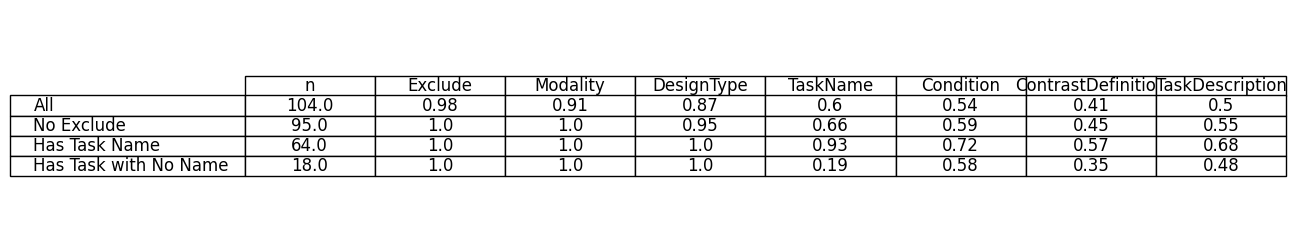

In [35]:
# Plot results as table
import matplotlib.pyplot as plt
from pandas.plotting import table

results = results.round(2)

fig, ax = plt.subplots(figsize=(7, 3))
ax.axis('off')
ax.axis('tight')
tbl = table(ax, results, loc='center', cellLoc='center', colWidths=[0.2]*len(results.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)
plt.show()

In [36]:
results

,n,Exclude,Modality,DesignType,TaskName,Condition,ContrastDefinition,TaskDescription
All,104,0.98,0.91,0.87,0.60,0.54,0.41,0.50
No Exclude,95,1.00,1.00,0.95,0.66,0.59,0.45,0.55
Has Task Name,64,1.00,1.00,1.00,0.93,0.72,0.57,0.68
Has Task with No Name,18,1.00,1.00,1.00,0.19,0.58,0.35,0.48


### Manual comparison

In [37]:
combined_df = pd.concat([pd.DataFrame(annotations_summary).T, pd.DataFrame(nv_task_gpt).T])

In [38]:
import pandas as pd
from IPython.display import display

pd.set_option('max_colwidth', 300)
    

def _display(df, pmcids=None):
    cols = list(set(df.keys()) - set(['pmcid']))
    if pmcids:
        df = df[df.pmcid.isin(pmcids)]
    for _, _df in df.groupby('pmcid'):
        display(_df[cols])

In [39]:
# Diff on Exclude

diff_exclude = all_scores_df[all_scores_df['Exclude'] == False].index.tolist()

if diff_exclude:
    _display(combined_df, diff_exclude)

,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
3555187,None,[],delavega_nv,None,MetaAnalysis,None,[],None
3555187,"[activity in the basal ganglia and cerebellum was significantly stronger for sensorimotor tasks, activity in cortical structures and the thalamus was significantly stronger for SRTT variants]","[motor learning, serial response time task]",NaN,[The study identified consistent activations across 70 motor learning experiments using activation likelihood estimation (ALE) meta-analysis. A global analysis of all tasks revealed a bilateral cortical-subcortical network consistently underlying motor learning across tasks.],None,[fMRI-BOLD],[Task-based],"[sensorimotor tasks, SRTT variants]"


,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
10634720,None,[],delavega-aliceoverlap,None,MetaAnalysis,None,[],None
10634720,"[exploration > exploitation, exploitation > exploration]",[Explore-Exploit Decision Making],NaN,"[Participants engage in tasks that require them to make decisions about whether to explore new options or exploit known ones, using various task designs such as n-armed bandit and foraging tasks.]",None,[fMRI-BOLD],[Task-based],"[Exploration, Exploitation]"


In [40]:
# From now on, we will exclude Excluded articles
combined_df = combined_df[~combined_df.index.isin(exclude_idx)]

In [41]:
# Diff on DesignType

diff_dt = all_scores_df[all_scores_df['DesignType'] < 1].index.tolist()

if diff_dt:
    _display(combined_df, diff_dt)

,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
6331309,None,[],delavega_nv,None,None,[StructuralMRI],[],None
6331309,"[Migraine vs Healthy Controls, RLS vs Healthy Controls, Migraine vs RLS, Comorbid Migraine and RLS vs Healthy Controls]",[MRI data acquisition],NaN,"[High-resolution T1-weighted images were acquired from 116 subjects: 27 RLS patients, 22 migraine patients, 22 patients with comorbid migraine and RLS, and 45 healthy controls.]",None,[StructuralMRI],[Task-based],"[Migraine, Restless Legs Syndrome, Comorbid Migraine and RLS, Healthy Controls]"


,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
7426775,None,[],delavega-aliceoverlap,None,None,[StructuralMRI],[],None
7426775,[Age-related structural changes in the brain.],[Brain Age Prediction],NaN,[Predicting chronological age from structural MRI scans using a deep learning model.],None,[StructuralMRI],[Task-based],[Age prediction based on structural MRI.]


,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
7582181,None,[],delavega-aliceoverlap,None,None,[StructuralMRI],[],None
7582181,[Social reward expectancy vs. social threat expectancy],[Imagining social interactions],NaN,[Participants were asked to vividly imagine themselves in a novel self-relevant event that was ambiguous with regards to possible social acceptance or rejection.],None,[StructuralMRI],[Task-based],"[Social reward expectancy, Social threat expectancy]"


,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
8564184,None,[],delavega-aliceoverlap,None,None,[StructuralMRI],[],None
8564184,"[GMV in ulcerative colitis vs. healthy controls, GMV in irritable bowel syndrome vs. healthy controls, Correlations between GMV and symptom severity, Correlations between GMV and chronic stress]",[Voxel-based morphometry],NaN,[Parallelized whole-brain voxel-based morphometry analyses in two patient cohorts with chronic visceral pain (ulcerative colitis in remission and irritable bowel syndrome) and healthy individuals.],None,[StructuralMRI],[Task-based],"[Chronic visceral pain, Healthy controls]"


,ContrastDefinition,TaskName,annotator_name,TaskDescription,Exclude,Modality,DesignType,Condition
9202476,None,[],delavega-aliceoverlap,None,None,"[fMRI-BOLD, DiffusionMRI]",[RestingState],None
9202476,"[PS > GS, GS > PS]",[match-to-sample (MTS) task],NaN,"[In this computerized task, subjects were presented with a complex figure in the middle of the screen. Then, a few patterns were shown in the periphery, from which one was matched with the presented pattern. In the first trials, two patterns were presented in the periphery, and it was increased ...",None,"[fMRI-BOLD, DiffusionMRI]",[Task-based],"[poor sleepers (PSs), good sleepers (GSs)]"


In [42]:
diff_dt

[3445793,
 3555187,
 5243799,
 6331309,
 6344321,
 7426775,
 7582181,
 8421705,
 8564184,
 9189080,
 9202476,
 10147761,
 10318245,
 10634720]

In [63]:
all_scores_df.loc[2686646]

Exclude                   True
TaskName                   0.8
Condition             0.913333
ContrastDefinition         1.0
DesignType                 1.0
Modality                   1.0
TaskDescription              0
Name: 2686646, dtype: object

It seems most misses by GPT were due to task performed *outside the scanner*, yet listed as Task-based design, which in this instance should only refer to Task-based fMRI design

In [64]:
# Diff on TaskName

has_taskname_df = combined_df[combined_df.index.isin(has_task_name)]

diff_taskname = all_scores_df[all_scores_df['TaskName'] < 0.8].index.tolist()

if diff_taskname:
    _display(has_taskname_df, diff_taskname)

,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4374765,"[spiders, control animals, IAPSnegative, IAPSneutral]","[MRS, fMRI-BOLD]",[Task-based],None,delavega_nv,None,"[SPIDERS > ANIMALS, IAPSnegative > IAPSneutral]",[fear inducing paradigm]
4374765,"[SPIDERS, ANIMALS, IAPSnegative, IAPSneutral]","[fMRI-BOLD, MRS]",[Task-based],"[Participants were presented with still pictures of spiders, control animals (birds, caterpillars, snails, and lizards), negative pictures from the International Affective Picture System (IAPS), and neutral pictures from IAPS. They performed a covert task of detecting the presence of a human in ...",NaN,None,"[SPIDERS > ANIMALS, IAPSnegative > IAPSneutral]",[Fear provocation paradigm]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5324609,None,"[fMRI-BOLD, fMRI-BOLD]",[Task-based],"[participants learned a set of visual discriminations via trial‐and‐error (learning phase), and were subsequently tested on their ability to generalize what they had learned (generalization phase). Both learning and generalization occurred within a single scanning session and took place in the c...",delavega-aliceoverlap,None,"[linear increases in activity across the four learning stage, HRF amplitude estimates relating to generalization test trials were correlated with generalization performance at the second‐level]",[acquired equivalence task]
5324609,"[rewarded, unrewarded]",[fMRI-BOLD],[Task-based],"[During scanning participants learned a set of visual discriminations via trial-and-error (learning phase), and were subsequently tested on their ability to generalize what they had learned (generalization phase). Both learning and generalization occurred within a single scanning session and too...",NaN,None,"[generalization performance, hippocampal activity during the test, BOLD activity during the final stage of learning]","[learning phase, generalization phase]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5776089,"[Task, Task+AgonistStim, Task+ControlStim]",[fMRI-BOLD],[Task-based],[he fMRI session was composed of nine rest–task cycles with 30 s for each period. Eyes were kept closed during scanning. The motor task consisted of repetitive alternating dorsiflexion and relaxation of the right foot (with range reaching 15°). Foot movements were paced following an audio cue th...,delavega-other,None,[“Task+AgonistStim minus Task”],"[Motor Task, Somatosensory Stimulation]"
5776089,"[Task, Task+AgonistStim, Task+ControlStim]",[fMRI-BOLD],[Task-based],[The motor task consisted of repetitive alternating dorsiflexion and relaxation of the right foot (with range reaching 15). Foot movements were paced following an audio cue that was sounded every 1.5 s.],NaN,None,"[Task+AgonistStim vs. Task, Task+ControlStim vs. Task, Task+AgonistStim vs. Task+ControlStim]","[right ankle dorsiflexion, ankle dorsiflexion coupled with simultaneous stimulation to the agonist muscle, ankle dorsiflexion coupled with simultaneous stimulation to a control area]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6219793,"[self-distanced, self-immersed]",[fMRI-BOLD],[Task-based],"[Following previous studies [ – ], negative social feedback was used to induce emotions for two reasons: (a) in daily life emotions are often caused by social stimuli [ , ] and (b) social feedback elicits emotional responses that are long enough to study emotion dynamics [ ]. The social feedback...",delavega_nv,None,None,[Social feedback paradigm]
6219793,"[Self-distanced perspective, Self-immersed perspective]",[fMRI-BOLD],[Task-based],[Participants were asked to adopt a self-immersed or self-distanced perspective while reading and thinking about negative social feedback.],NaN,None,"[Self-distanced > Self-immersed, Self-immersed > Self-distanced]",[Self-distanced vs. self-immersed perspective]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6699247,None,"[EEG, fMRI-BOLD, MRS]",[Task-based],"[In this task, a simple line drawing of an object is presented (250 ms), and following a short delay (75 ms), a word appears. Subjects are instructed to respond by indicating whether the word was a semantic match (50% of trials) or non-match (unmatched, 50% of trials) to the preceding picture. P...",delavega_nv,None,None,[picture–word verification task]
6699247,"[matched, in-category, out of category]",[fMRI-BOLD],[Task-based],"[Participants performed a picture-word matching task, in which words were either matched by preceding pictures, or were unmatched by semantically related or unrelated pictures.]",NaN,None,"[IC vs. matched, OC vs. matched]",[picture-word matching task]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
7018765,"[“both correct”, “costly error”, participant responded incorrectly, both the participant and their partner responded incorrectly,]",[fMRI-BOLD],[Task-based],"[his task builds on past studies that have utilized error processing paradigms in the study of ER (e.g., ; ; ) by specifically examining dyadic error processing. Parent-adolescent dyads completed the TEAM task while simultaneously undergoing fMRI scanning. This task was developed to examine b...",delavega-aliceoverlap,None,"[“costly error” – “both correct”, “costly error”, “both correct”]",[Testing Emotional Attunement and Mutuality (TEAM)]
7018765,"[costly error condition, both correct condition]",[fMRI-BOLD],[Task-based],"[The TEAM task is an event-related design and consists of 17 trials during which participants first see a pattern of colored arrows presented sequentially on the screen for 3 s, twice in a row (totaling 6 s). They are then given 4 s to reconstruct the sequence by pressing colored buttons on a re...",NaN,None,[costly error vs. both correct],[TEAM task]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
11063816,"[open-loop, delay, open-loop, no-delay, closed-loop, delay, closed-loop, no-delay]","[fMRI-BOLD, fMRI-BOLD]",[Task-based],"[On each trial, a cue and six potential targets were presented simultaneously on the screen. The cue was presented in the middle of the screen with the six possible targets; one target and five foils form the same category (e.g., if the target was hammer, the five foils would be other randomly s...",delavega-other,None,"[people, locations, objects, nontarget reinstatement effect, collapsing across the delay and no-delay condition, nontarget reinstatement effect differed between the delay and no-delay conditions , differences between closed- and open-loops in the cue and target regions in the delay and no-delay ...",[six-alternative forced-choice cued-recognition task]
11063816,"[Delay, No-delay]",[fMRI-BOLD],[Task-based],"[Participants learned events that comprised multiple overlapping pairs of event elements (e.g., person-location, object-location, location-person). Encoding occurred either immediately before or 24h before retrieval. Using fMRI during the retrieval of events, the study assessed whether episodic ...",NaN,None,"[closed-loop vs open-loop, immediate vs delayed retrieval]",[Episodic memory retrieval]


In [65]:
has_taskname_df

,pmcid,DesignType,annotator_name,Exclude,Modality,TaskName,TaskDescription,Condition,ContrastDefinition
2241626,2241626,[Task-based],delavega-aliceoverlap,None,[fMRI-BOLD],"[mental calculation task, language comprehension task]","[In the present research, our goal was to define a simple fMRI test, less than 5 minutes long, that could delineate, in a subject-specific manner, those cerebral circuits. A functional sequence was added to each functional imaging session performed in our lab (Figure ), taking advantage of the ...",None,None
2686646,2686646,[Task-based],delavega_nv,None,[fMRI-BOLD],[one-back task],None,"[words, objects, scrambled objects]","[words > fixation, objects > scrambled objects]"
3078751,3078751,[Task-based],delavega-other,None,[fMRI-BOLD],[movement observation paradigm],"[participants had to register auditory cues that determined what movement the dancer was to perform next, and watch the ensuing movements, participants watched a dancer performing according to cue, but occasionally making mistakes. Previous to playing the task, the participants were instructed o...","[predicted, prediction-violating movements, correct movements, incorrect movements, first dissimilar transition cues, switch cues, repetition cues, null events]",None
4115625,4115625,[Task-based],delavega-other,None,[fMRI-BOLD],[Voice localizer paradigm],"[The voice localizer includes a variety of different vocal sounds, not exclusively female or male voices, but also speech and non-speech of women, men and infants and non-vocal sounds (e.g., environmental sounds), Subjects were instructed to close their eyes and passively listen to a large varie...","[vocal, non-vocal ]","[vocal vs. non-vocal, male > female, female > male]"
4179768,4179768,[Task-based],delavega_nv,None,[fMRI-BOLD],[single food choice task],"[During the functional MRI scan, participants performed a food choice task (Figure ). In this ask, participants made 100 choices. In every trial, they viewed one of the study stimuli (3000 ms, choice period) and subsequently had to indicate with a button press (1500 ms, button press period) whe...","[HE choice periods, LE choice periods, button press screen, practice, missed]",None
...,...,...,...,...,...,...,...,...,...
9308012,9308012,[Task-based],NaN,None,[fMRI-BOLD],[Trust Game],"[Participants played an economic trust game as the investor with three partners (friend, stranger, and computer) who played the role of investee.]","[Reciprocate, Defect]","[Reciprocate > Defect, Friends > Strangers, Friends > Computers]"
9454014,9454014,"[RestingState, Task-based]",NaN,None,[fMRI-BOLD],[Food Cue Reactivity Task],"[The Food Cue Reactivity Task was modified in-house from the Alcohol Cue Reactivity Task. It consisted of 44 food images [22 high energy-dense foods (HED), e.g., ice cream, cookies; 22 low energy-dense foods (LED), e.g., salad, fruit] matched on valence, arousal, image complexity, brightness, an...","[deflation, sham-deflation]","[food images vs. degraded images, deflation vs. sham-deflation]"
9837608,9837608,[Task-based],NaN,None,[fMRI-BOLD],[movement synchronization],"[Participants were scanned while engaged in movement synchronization, using a novel dyadic interaction paradigm.]","[random, free, sync]","[sync > random, free > random]"
9910278,9910278,[Task-based],NaN,None,[fMRI-BOLD],"[Emotion Reappraisal, Dietary Self-Control]","[Participants were presented with emotional stimuli and instructed to either view or reappraise the content to regulate their feelings. They rated their emotions after each trial., Participants made choices about whether to eat presented food items, which were tailored based on individual taste ...","[Reappraise, View, Healthy, Unhealthy]","[Reappraisal Success > View, Self-Control Success > No Challenge]"


In [66]:
# Doesn't have TaskName (according to annotations)

has_notaskname_df = combined_df[combined_df.index.isin(has_task_name) == False]

diff_notaskname = all_scores_df[all_scores_df['TaskName'] < 0.8].index.tolist()

if diff_notaskname:
    _display(has_notaskname_df, diff_notaskname)

,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
3825257,None,[fMRI-BOLD],[RestingState],None,delavega_nv,None,None,[]
3825257,"[task-unrelated thought, comprehension]",[fMRI-BOLD],[RestingState],[Participants read three excerpts from the official translation of Bill Bryson's 'A Short History of Everything' on a computer screen in an individual testing booth. Text was presented one sentence at a time and participants received experience sampling probes at random intervals.],NaN,None,"[better comprehension vs. worse comprehension, higher task focus vs. lower task focus]",[reading]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4110030,None,[fMRI-BOLD],[RestingState],None,delavega_nv,None,None,[]
4110030,"[Menstrual phase (day 24), Follicular phase (day 8-12), Luteal phase (day 20-22)]",[fMRI-BOLD],[RestingState],[Participants completed three sessions of resting state fMRI. They were instructed to relax and keep their eyes closed during scanning.],NaN,None,"[Women > Men in right dorsal network, Women > Men in anterior network]",[Resting State fMRI]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4386762,None,[fMRI-BOLD],[RestingState],None,delavega_nv,None,None,[]
4386762,"[Healthy elderly, Alzheimer's Disease (AD), Mild Cognitive Impairment (MCI)]",[fMRI-BOLD],[RestingState],"[Subjects were instructed to keep their eyes closed, to not think of anything in particular and to refrain from falling asleep.]",NaN,None,"[Healthy elderly vs. Alzheimer's Disease, Healthy elderly vs. Mild Cognitive Impairment, Alzheimer's Disease vs. Mild Cognitive Impairment]",[Resting state fMRI]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4488375,None,[fMRI-BOLD],[Task-based],[The task used in this experiment was programmed using PsychoPy [ ]. The task featured a 0-back and a 1-back condition that continuously switched from one another throughout the experimental session (see ). Our paradigm is broadly similar to the paradigm used by Smallwood and colleagues [ ] and...,delavega_nv,None,None,[n/a]
4488375,"[0-back, 1-back]",[fMRI-BOLD],[Task-based],[Participants alternated between two tasks. One task involved observing non-coloured shapes presented at fixation waiting for the presentation of a coloured slide at which point they would indicate using a button press which side of the fixation cross a target shape was (0-back). In the other ta...,NaN,None,"[1-back > 0-back sustained responses, 1-back > 0-back target transient responses]","[0-back, 1-back]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4526228,None,"[fMRI-BOLD, DiffusionMRI]",[RestingState],None,delavega_nv,None,None,[]
4526228,"[Low-intensity physical activity (LI-PA), Moderate-to-vigorous physical activity (MV-PA)]",[fMRI-BOLD],[RestingState],[Participants were asked to lie still with eyes closed during the resting state fMRI acquisition.],NaN,None,[LI-PA and MV-PA > Sedentary behavior],[Resting State]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4547715,"[liked, uninteresting, romantic, non-romantic]",[fMRI-BOLD],[Task-based],[A) The task was conducted in an event-related design. Six trials from either the liked or the uninteresting male acquaintance were combined in a set. Each set contained pseudo-randomized four target trials (shown in red) with two control trials (shown in blue). (B) Each trial was created by a 2...,delavega_nv,None,None,[n/a]
4547715,"[Liked giver vs. Uninteresting giver, Romantic gifts vs. Non-romantic gifts]",[fMRI-BOLD],[Task-based],"[Participants judged the attractiveness of gifts received from two male acquaintances, one preferred and one uninteresting, on a 9-point scale.]",NaN,None,"[Liked giver > Uninteresting giver, Romantic gifts > Non-romantic gifts from liked giver, Romantic gifts > Non-romantic gifts from uninteresting giver]",[Gift attractiveness judgment]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
4914983,None,[fMRI-BOLD],[Task-based],None,delavega_nv,None,None,[n/a]
4914983,"[First viewing, Second viewing]",[fMRI-BOLD],[Task-based],[Three comedy clips were shown twice to 20 volunteers during functional magnetic resonance imaging (fMRI).],NaN,None,"[First viewing > Second viewing, Humorousness ratings]",[Viewing and re-viewing of comedy movies]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5090046,None,[fMRI-BOLD],[RestingState],None,delavega-aliceoverlap,None,None,[]
5090046,"[High frequency, Low frequency, High imageability, Medium imageability, Low imageability, Category fluency, Letter fluency]",[fMRI-BOLD],"[RestingState, Task-based]","[Participants performed a synonym judgement task to index the capacity to understand the meaning of an external stimulus., Participants had 1min to generate as many unique words as possible belonging to a semantic category (category fluency) or starting with a specific letter (letter fluency).]",NaN,None,"[High frequency vs. Low frequency, High imageability vs. Low imageability, Category fluency vs. Letter fluency]","[Synonym Judgement, Verbal Fluency]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5552726,None,[fMRI-BOLD],[RestingState],None,delavega-other,None,None,[]
5552726,[Asymptomatic carotid artery stenosis patients undergoing CAS before and after intervention.],"[fMRI-BOLD, StructuralMRI]",[RestingState],"[Cognition assessment including the Montreal Cognitive Assessment Beijing Version, the Minimum Mental State Examination, the Digit Symbol Test, the Rey Auditory Verbal Learning Test, and the Verbal Memory Test.]",NaN,None,[3 months after CAS vs. baseline],[Cognition assessment]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5607552,"[distorted sentences, intact sentences, second presentation of the distorted sentences]","[fMRI-BOLD, fMRI-BOLD]",[Task-based],"[a degraded sentence is first experienced as very difficult to understand and, after a single presentation of its intact counterpart, the intelligibility of this same degraded sentence reaches near‐perfect level., functional run consisted of 9 D‐I‐D stimulus sets, each of which comprised three b...",delavega-aliceoverlap,None,"[second distorted versus first distorted, intact versus first distorted, intact versus second distorted]",[n/a]
5607552,"[Distorted sentences before intact presentation, Intact sentences, Distorted sentences after intact presentation]",[fMRI-BOLD],[Task-based],"[Subjects listened to acoustically distorted sentences, followed by intact versions, and then the distorted sentences were presented again.]",NaN,None,"[Second distorted vs. first distorted, Intact vs. first distorted, Intact vs. second distorted]",[Speech Comprehension]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5662713,None,[fMRI-BOLD],[Task-based],[Participants watched 24 short videos while in the MRI scanner. The videos lasted on average 38 seconds (range 29–48 s) and were taken from short films or videos posted on www.YouTube.com . All videos depicted a short narrative and were presented without sound. The stories centered around one...,delavega_nv,None,None,[n/a]
5662713,"[Encoding, Immediate Retrieval, Delayed Retrieval]",[fMRI-BOLD],[Task-based],"[Participants watched 24 short videos while in the MRI scanner. The task involved encoding the videos, immediate retrieval, and delayed retrieval after one week.]",NaN,None,"[Enc/ImRet, Enc/DelRet, ImRet/DelRet]",[Memory retrieval]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5716095,"[family, self]",[fMRI-BOLD],[Task-based],None,delavega_nv,None,None,[n/a]
5716095,"[Self-condition, Family-condition]",[fMRI-BOLD],[Task-based],[Participants saw individuals expressing emotional distress in negative contexts and were instructed to perceive the target face as either their family member or themselves.],NaN,None,[self > family],[Empathy Task]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
5895040,"[confidence, follow]",[fMRI-BOLD],[Task-based],"[In the perceptual task, subjects were asked to report the brighter of two stimuli on each trial, In the memory task, subjects began each miniblock by learning a set of nine consecutively presented stimuli]",delavega_nv,None,None,"[n/a, n/a]"
5895040,"[confidence, follow]",[fMRI-BOLD],[Task-based],"[In the perceptual task, subjects were asked to report the brighter of two stimuli on each trial., In the memory task, subjects began each miniblock by learning a set of nine consecutively presented stimuli. A stimulus from this set was then presented on each subsequent trial (in randomized orde...",NaN,None,"[memory confidence > memory follow, perception confidence > perception follow]","[perceptual task, memory task]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6102316,"[unresolved, non-habitual, habitual, “verbal”]","[fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD, fMRI-BOLD]",[Task-based],None,delavega_nv,None,None,[n/a]
6102316,"[unresolved interactions, non-habitual interactions, habitual interactions, verbal interactions]",[fMRI-BOLD],[Task-based],[Participants watched a 20-min movie narrative encompassing verbal and non-verbal social interactions.],NaN,None,"[verbal > non-verbal, non-verbal > verbal, unresolved > habitual, habitual > unresolved, non-habitual > habitual, non-habitual > unresolved]",[Naturalistic viewing of social interactions]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6331309,None,[StructuralMRI],[],None,delavega_nv,None,None,[]
6331309,"[Migraine, Restless Legs Syndrome, Comorbid Migraine and RLS, Healthy Controls]",[StructuralMRI],[Task-based],"[High-resolution T1-weighted images were acquired from 116 subjects: 27 RLS patients, 22 migraine patients, 22 patients with comorbid migraine and RLS, and 45 healthy controls.]",NaN,None,"[Migraine vs Healthy Controls, RLS vs Healthy Controls, Migraine vs RLS, Comorbid Migraine and RLS vs Healthy Controls]",[MRI data acquisition]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6382839,"[disorder-related , neutral narrative]",[fMRI-BOLD],[Task-based],None,delavega-other,None,[disorder-related > neutral scripts],[n/a]
6382839,"[disorder-related, neutral]",[fMRI-BOLD],[Task-based],[Participants were exposed to disorder-related and neutral narrative scripts while brain activation was measured with fMRI. They were encouraged to imagine the narrative scripts as vividly as possible.],NaN,None,[disorder-related vs. neutral scripts],[script-driven imagery]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6391069,"[mother’s voice, unfamiliar female voices, environmental sounds, catch trials]",[fMRI-BOLD],[Task-based],"[Auditory stimuli were presented in 10 separate runs, each lasting 4 min. One run consisted of 56 trials of mother’s voice, unfamiliar female voices, environmental sounds and catch trials, which were pseudo-randomly ordered within each run. Stimulus presentation order was the same for each subje...",delavega_nv,None,"[unfamiliar female voices > environmental sounds, mother’s voice > unfamiliar female voices]",[n/a]
6391069,"[Mothers voice, Unfamiliar voices, Environmental sounds]",[fMRI-BOLD],[Task-based],"[Participants listened to auditory stimuli including mothers voice, unfamiliar female voices, and environmental sounds while undergoing fMRI scanning.]",NaN,None,"[Mothers voice > Unfamiliar voices, Unfamiliar voices > Environmental sounds]",[Voice Processing]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6397754,"[food, non-food]",[fMRI-BOLD],[Task-based],"[For this task, all participants were told that they would watch a clip from a nature documentary featuring Canadian bighorn sheep, and at times various words would appear and move around on the screen, but they were told to “avoid reading these distractor words whenever they appear.” On average...",delavega_nv,None,"[words present vs. absent, words-versus-film]","[n/a, watched]"
6397754,"[Effortful self-control, Food cue exposure]",[fMRI-BOLD],[Task-based],"[Participants were required to actively inhibit reading a series of words that appeared on the screen over the course of seven minutes., Participants engaged in a food-cue reactivity task involving food commercials.]",NaN,None,"[words present vs. absent, food events vs. control events]","[Effortful self-control task, Food cue reactivity task]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
6821801,None,[fMRI-BOLD],[Task-based],"[During the event-related fMRI sessions, participants performed either purchasing or perceptual decisions in alternating blocks (Fig. ). Each good was presented twice: once during the purchasing decision and once during the perceptual decision. Before each block started, both blocks were cued v...",delavega_nv,None,None,[n/a]
6821801,"[Hedonic goods, Utilitarian goods]",[fMRI-BOLD],[Task-based],"[Participants indicated their willingness to pay a specific price for that book during purchasing decisions., Participants indicated the total number of people and lines on the book cover during perceptual decisions.]",NaN,None,"[Explicit hedonic values vs. explicit utilitarian values, Task-irrelevant hedonic values vs. task-irrelevant utilitarian values]","[Purchasing decisions, Perceptual decisions]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
7426775,None,[StructuralMRI],[],None,delavega-aliceoverlap,None,None,[]
7426775,[Age prediction based on structural MRI.],[StructuralMRI],[Task-based],[Predicting chronological age from structural MRI scans using a deep learning model.],NaN,None,[Age-related structural changes in the brain.],[Brain Age Prediction]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
7582181,None,[StructuralMRI],[],None,delavega-aliceoverlap,None,None,[]
7582181,"[Social reward expectancy, Social threat expectancy]",[StructuralMRI],[Task-based],[Participants were asked to vividly imagine themselves in a novel self-relevant event that was ambiguous with regards to possible social acceptance or rejection.],NaN,None,[Social reward expectancy vs. social threat expectancy],[Imagining social interactions]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
7859438,"[parallel, isolated, rest, auditory, visual, environmental sounds, vocal sounds, scene images, face images]",[fMRI-BOLD],[Task-based],"[It measures predominantly memory encoding, but also perception and attention in both the auditory and visual domains within 10 min of fMRI acquisition time using simple instructions. To our knowledge, memory-encoding paradigms so far presented stimuli of one sensory condition or did face–name a...",delavega_nv,None,"[auditory and visual blocks (c1), (c2) environmental sounds vs. vocal sounds masked by auditory activity greater than visual activity, (c3) face images vs. scene images masked by visual activity greater than auditory activit, c4) all (visual and auditory) hits vs. all misses (sensory-unspecific ...",[n/a]
7859438,"[Auditory stimuli, Visual stimuli, Rest blocks]",[fMRI-BOLD],[Task-based],[A functional MRI paradigm designed to map memory encoding across auditory and visual sensory conditions using a mixed design.],NaN,None,"[Auditory > Visual, Environmental > Vocal, Face > Scene, Positive ESA (hits > misses), Negative ESA (misses > hits), Auditory > rest, Visual > rest, Auditory events > rest, Visual events > rest]",[Memory Encoding Task]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
8104963,None,[fMRI-BOLD],[Task-based],"[The main experimental session was organized in three blocks. In the first block, participants saw a fixation cross (1 s) followed by one video (3 s) and were asked to estimate the amount of pain experienced by the person in the video, by moving a randomly-presented rectangular cursor on a Visua...",delavega_nv,None,None,[n/a]
8104963,[Pain facial expressions],[fMRI-BOLD],[Task-based],"[Participants appraised the pain of facial expression video-clips, and subsequently were confronted with two feedbacks: the self-report of the person in pain and the average opinion of 20 medical practitioners.]",NaN,None,"[Target > MPs, MPs > Target]",[Pain assessment]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
8443248,"[genuine pain, genuine no pain, pretended pain, pretended no pain]",[fMRI-BOLD],[Task-based],"[Participants were explicitly instructed to recreate the feelings of the demonstrators shown in the videos as vividly and intensely as possible. Based on the validation and pilot study, the painful expressions for the genuine and pretended conditions were matched. We also counterbalanced the...",delavega_nv,None,"[main effect of genuine: pain – no pain, main effect of pretended: pain – no pain, interaction: genuine (pain – no pain) – pretended (pain – no pain)]",[n/a]
8443248,"[Genuine pain, Pretended pain, Pain, No pain]",[fMRI-BOLD],[Task-based],[Participants watched video clips of people either feeling or pretending to feel pain.],NaN,None,"[genuine: pain > no pain, pretended: pain > no pain, genuine (pain > no pain) > pretended (pain > no pain)]",[Watch video clips of genuine vs. pretended pain]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
8564184,None,[StructuralMRI],[],None,delavega-aliceoverlap,None,None,[]
8564184,"[Chronic visceral pain, Healthy controls]",[StructuralMRI],[Task-based],[Parallelized whole-brain voxel-based morphometry analyses in two patient cohorts with chronic visceral pain (ulcerative colitis in remission and irritable bowel syndrome) and healthy individuals.],NaN,None,"[GMV in ulcerative colitis vs. healthy controls, GMV in irritable bowel syndrome vs. healthy controls, Correlations between GMV and symptom severity, Correlations between GMV and chronic stress]",[Voxel-based morphometry]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
8927597,"[2Back, Classification, SWr, SWi, RP]",[fMRI-BOLD],[Task-based],None,delavega_nv,None,None,[n/a]
8927597,"[2Back-SWr, 2Back-SWi, 2Back-RP, Classification-SWr, Classification-SWi, Classification-RP]",[fMRI-BOLD],[Task-based],[Participants performed a 2-back updating task (2Back) and a classification task (Classification) with numbers or letters. The task involved classifying stimuli as odd/even or vowel/consonant and determining whether the current target was identical to the stimulus presented two trials before.],NaN,None,[(2Back-SWi>2Back-SWr)>(Classification-SWi>Classification-SWr)],"[2-back updating task, classification task]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
8975992,None,[fMRI-BOLD],[Task-based],None,delavega_nv,None,"[vse_new > vpe_old, geo, groom > all non-ge]",[n/a]
8975992,"[Visual spatial information, Semantic spatial information]",[fMRI-BOLD],[Task-based],[Participants watched the movie Forrest Gump and listened to its audio-description.],NaN,None,"[vse_new > vpe_old, geo, groom > non-spatial]","[Watching a movie, Listening to audio-description]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
9202476,None,"[fMRI-BOLD, DiffusionMRI]",[RestingState],None,delavega-aliceoverlap,None,None,[]
9202476,"[poor sleepers (PSs), good sleepers (GSs)]","[fMRI-BOLD, DiffusionMRI]",[Task-based],"[In this computerized task, subjects were presented with a complex figure in the middle of the screen. Then, a few patterns were shown in the periphery, from which one was matched with the presented pattern. In the first trials, two patterns were presented in the periphery, and it was increased ...",NaN,None,"[PS > GS, GS > PS]",[match-to-sample (MTS) task]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
9729227,None,[fMRI-BOLD],[RestingState],None,delavega_nv,None,None,[]
9729227,[Attention networks],[fMRI-BOLD],[RestingState],[We used 110 7T resting-state functional MRI datasets from the Human Connectome Project S1200. Images were preprocessed and registered to the MNI152 space as specified in the Human Connectome Project protocol.],NaN,None,[Ventral Attention Network (VAN) vs. Dorsal Attention Network (DAN)],[Resting-state functional imaging]


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
10028637,None,[fMRI-BOLD],"[RestingState, Task-based]",None,delavega_nv,None,None,[n/a]
10028637,"[wakefulness, moderate anaesthesia]",[fMRI-BOLD],"[Task-based, RestingState]","[Participants performed a computerized auditory target detection task (50 trials) to assess individual responsiveness differences during moderate anaesthesia. Sound was presented, and participants pressed a button upon hearing an auditory beep., Participants listened to a plot-driven auditory na...",NaN,None,"[Responses during wakefulness vs. responses during moderate anaesthesia, Functional connectivity within and between the DAN, ECN, and DMN during wakefulness vs. moderate anaesthesia]","[auditory target detection task, narrative listening, resting state]"


,Condition,Modality,DesignType,TaskDescription,annotator_name,Exclude,ContrastDefinition,TaskName
10031743,None,"[StructuralMRI, DiffusionMRI, fMRI-CBF]",[RestingState],None,delavega_nv,None,None,[]
10031743,[Patients with schizophrenia spectrum disorders],"[fMRI-CBF, StructuralMRI, DiffusionMRI]",[RestingState],[This study tested whether four FTD dimensions differ in their association with brain perfusion and brain structure.],NaN,None,"[rsCBF and GMV associations with TALD subscales controlling for age, medication, total intracranial volume, and for variance of the 3 other TALD subscales.]",[Neural Correlates of Formal Thought Disorder Dimensions in Psychosis]


We can add post-hoc rules to further clean up these results

e.g. if Resting-State, ignore Task Name features

Double check: 5090046

In [76]:
##  Focus on TaskDescription

has_notaskname_df = combined_df[combined_df.index.isin(has_task_name) == False]

In [111]:
def _loop_print_row(df, fields=['TaskName', 'TaskDescription']):
    for _, row in df.iterrows():
        for f in fields:
            if row[f]:
                for x in row[f]:
                    if x:
                        print(f'{f}:', x)
            else:
                print(f'{f}: n/a')

def clean_print_by_pmcid(df):
    for pmcid, _df in df.groupby('pmcid'):
        print('PMCID:', pmcid)

        # For row in annot, compare TaskDescription to extract
        print('--- Annotator ---')
        _loop_print_row(_df.loc[_df.annotator_name.isna() == False])

        print('--- Extract ---')
        _loop_print_row(_df.loc[_df.annotator_name.isna()])

        print('')

In [112]:
clean_print_by_pmcid(has_taskname_df)

PMCID: 2241626
--- Annotator ---
TaskName: mental calculation task
TaskName: language comprehension task
TaskDescription: In the present research, our goal was to define a simple fMRI test, less than 5 minutes long, that could delineate, in a subject-specific manner, those cerebral circuits. A functional sequence was added to each functional imaging session performed in our lab (Figure  ), taking advantage of the continuous flow of volunteers recruited for various protocols. Because we wanted to capture the maximal amount of functional information in the minimum amount of time, we designed the sequence according the following challenging constraints: 

▪ the sequence had to be short, so as to disrupt as little as possible the main protocol. We choose 5 minutes for performing 100 trials. 

▪ we aimed to obtain for each subject a description of different levels of functional architecture, from sensori-motor areas (perception and action) to more associative areas involved in reading, lang

### Notes

- Annotation improvements- need more structured annotations as its not always clear if there is 1-2 tasks when multiple sections were annotated for the same task
- Prompt improvements- moving to structured extraction would help pair task name w/ description
   - Better instruction would be to specify to describe task in 1-3 sentences and have a separate prompt that required more details design information. 
- Overall assessment- Descriptions are reasonable if sometimes short and vague. The short description is probably quite useful for decision making in a semi-automated meta-analysis context
- Outside of scanner tasks as proper annotations / extractions


In the future, only show Task Names / Description from non-abstract if that's not already the case
TaskDescription
TaskDesignDetails (verbatim)


In [114]:
clean_print_by_pmcid(has_notaskname_df)

PMCID: 3825257
--- Annotator ---
TaskName: n/a
TaskDescription: n/a
--- Extract ---
TaskName: reading
TaskDescription: Participants read three excerpts from the official translation of Bill Bryson's 'A Short History of Everything' on a computer screen in an individual testing booth. Text was presented one sentence at a time and participants received experience sampling probes at random intervals.

PMCID: 4110030
--- Annotator ---
TaskName: n/a
TaskDescription: n/a
--- Extract ---
TaskName: Resting State fMRI
TaskDescription: Participants completed three sessions of resting state fMRI. They were instructed to relax and keep their eyes closed during scanning.

PMCID: 4386762
--- Annotator ---
TaskName: n/a
TaskDescription: n/a
--- Extract ---
TaskName: Resting state fMRI
TaskDescription: Subjects were instructed to keep their eyes closed, to not think of anything in particular and to refrain from falling asleep.

PMCID: 4488375
--- Annotator ---
TaskName: n/a
TaskDescription: The task us